### Machine Learning Model Development

1. Datasource: 
    https://archive.ics.uci.edu/ml/datasets/ILPD+(Indian+Liver+Patient+Dataset)

2. Objective:
    - To correctly classify a person a patient or non-patient
    
3. Encoding:
    - Non-Patient = 0 | Patient = 1
    
4. Metrics:
    -  Overall Accuracy & Recall.
    
5. Scope:
    - Limited to the models being tried out here with a small set of hypertuned parameters. [Owing to hardware limitations]
    - Not treating outliers as the sample size is small and as such downsampling is carried out.

6. Excerpts from Exploratory Data Analyses (EDA)
    - Either direct or total bilirubin can be removed.
    - MinMaxScaler would be better.
    - Strong case for upsampling / downsampling.
    

In [1]:
# Import Relevant Libraries

# -------------- Basic Libraries ----------------------
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', 10000)
pd.options.display.width=None
from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from scipy import stats

# --------------- sklearn libraries ---------------------

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import catboost as cb

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential

In [2]:
# Global constants

RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.2  # test_size where used is assigned TESTSIZE

In [3]:
PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"
DATASET = r"\Dataset_Indian_Liver_Patient_10x1.csv"
PREFIX = r"\Liver_Patient_"

# Specify number of features and targets

n_features = 10
n_target = 1

In [4]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.round(decimals=3)
df = df.drop(columns=['Total_Bilirubin', 'Total_Protiens', 'Albumin_and_Globulin_Ratio'])

# df = shuffle(df, random_state=RND_STATE) # Shuffling it intntionally

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

In [5]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [6]:
df.head()

,Age,Gender,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Albumin,Dataset
0,65,Female,0.1,187,16,18,3.3,Patient
1,62,Male,5.5,699,64,100,3.2,Patient
2,62,Male,4.1,490,60,68,3.3,Patient
3,58,Male,0.4,182,14,20,3.4,Patient
4,72,Male,2.0,195,27,59,2.4,Patient


In [7]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [8]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [9]:
df.head()

,Age,Gender,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Albumin,Dataset
0,65,0,0.1,187,16,18,3.3,1
1,62,1,5.5,699,64,100,3.2,1
2,62,1,4.1,490,60,68,3.3,1
3,58,1,0.4,182,14,20,3.4,1
4,72,1,2.0,195,27,59,2.4,1


In [10]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [11]:
print(df.isnull().sum(), end='\n\n')

Age                           0
Gender                        0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Albumin                       0
Dataset                       0
dtype: int64



In [12]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)

In [13]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [14]:
print(df.isnull().sum(), end='\n\n')

Age                           0
Gender                        0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Albumin                       0
Dataset                       0
dtype: int64



In [15]:
"""
    1. Cell for removing outliers.
    2. Based on Z-score.
"""
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] # Removing the Outliers using Z-Scored Method

In [16]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['Age', 'Gender', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Albumin']

List of Targets: ['Dataset']

List of Categorical Variables: ['Gender', 'Dataset']

List of Categorical Targets ['Dataset']



In [17]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [18]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                            |   count |    mean |     std |   min |   25% |   50% |   75% |   max |
|----------------------------|---------|---------|---------|-------|-------|-------|-------|-------|
| Age                        |     542 |  44.755 |  16.338 |     4 |    33 |    45 |    58 |    90 |
| Gender                     |     542 |   0.755 |   0.431 |     0 |     1 |     1 |     1 |     1 |
| Direct_Bilirubin           |     542 |   1.017 |   1.726 |   0.1 |   0.2 |   0.3 |     1 |   9.5 |
| Alkaline_Phosphotase       |     542 | 257.266 | 145.581 |    63 |   174 | 204.5 |   289 |   950 |
| Alamine_Aminotransferase   |     542 |  56.456 |  70.892 |    10 |    22 |    33 |    56 |   622 |
| Aspartate_Aminotransferase |     542 |  77.489 | 117.397 |    10 | 24.25 |    40 |    75 |   950 |
| Albumin                    |     542 |   3.171 |   0.803 |   0.9 |   2.6 |   3.1 |   3.8 |   5.5 |
| Dataset                    |     542 |   0.694 |   0.461 |     0 |     0 |     1 |     1 

In [19]:
# Train-Test Split

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=RND_STATE)


In [20]:
"""
1. Command block for Downsampling Majority Class.

2. Downsampling applied only to the training dataset.

"""

from sklearn.utils import resample

df_train = X_train.join(y_train) # Combine the X, y train dataset

# Separate majority and minority classes

n_class = df_train.iloc[:, -1:].value_counts(sort=False)

print("Class Count Before Downsampling", n_class)

if n_class[0] > n_class[1]:
    df_majority = df_train[df_train.Dataset==0] # df_majority = df_train[df_train.iloc[:, -1:] == 0]
    df_minority = df_train[df_train.Dataset==1] # df_minority = df_train[df_train.iloc[:, -1:] == 1]
    n_sample = n_class[1]
else:
    df_majority = df_train[df_train.Dataset==1] # df_majority = df_train[df_train.iloc[:, -1:] == 1]
    df_minority = df_train[df_train.Dataset==0] # df_minority = df_train[df_train.iloc[:, -1:] == 0]
    n_sample = n_class[0]

df_majority_downsampled = resample(df_majority, replace=False, n_samples=n_sample, random_state=RND_STATE)
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled.Dataset.value_counts()

X_train = df_downsampled.drop(columns=targlst)
y_train = df_downsampled.drop(columns=featlst)

Class Count Before Downsampling Dataset
0          136
1          297
dtype: int64


In [21]:
print("Train Dataset - Features: ")

Train Dataset - Features: 


In [22]:
X_train.head()

,Age,Gender,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Albumin
284,18,1,0.3,300,30,48,4.0
461,28,0,0.2,309,55,23,4.1
318,38,1,2.2,216,179,232,4.5
205,45,1,1.2,163,28,22,4.0
574,32,1,6.0,515,48,92,2.4


In [23]:
print("Test Dataset - Features: ")

Test Dataset - Features: 


In [24]:
X_test.head()

,Age,Gender,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Albumin
252,65,1,0.3,258,48,40,3.9
63,57,1,0.2,208,35,97,2.1
222,47,1,0.2,265,40,28,4.0
238,35,0,0.2,190,40,35,4.7
474,35,1,1.1,226,33,135,2.7


In [25]:
print("Train Dataset - Target: ")

Train Dataset - Target: 


In [26]:
y_train.head()

,Dataset
284,1
461,1
318,1
205,1
574,1


In [27]:
print("Test Dataset - Target: ")

Test Dataset - Target: 


In [28]:
y_test.head()

,Dataset
252,0
63,1
222,1
238,0
474,0


In [29]:
# Scaling

scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc_df = pd.DataFrame(scaler.fit_transform(X_train), columns=featlst)
X_test_sc_df = pd.DataFrame(scaler.transform(X_test), columns=featlst)

In [30]:
print("Train Dataset Scaled - Features:")

Train Dataset Scaled - Features:


In [31]:
X_train_sc_df.head()

,Age,Gender,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Albumin
0,-1.584344,0.611341,-0.347600,0.371815,-0.299417,-0.178774,0.968005
1,-0.979853,-1.635749,-0.410048,0.436733,0.090330,-0.453936,1.094106
2,-0.375362,0.611341,0.838923,-0.234078,2.023474,1.846415,1.598507
3,0.047781,0.611341,0.214437,-0.616369,-0.330597,-0.464942,0.968005
4,-0.738057,0.611341,3.211967,1.922615,-0.018800,0.305510,-1.049600


In [32]:
print("Test Dataset Scaled - Features:")

Test Dataset Scaled - Features:


In [33]:
X_test_sc_df.head()

,Age,Gender,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Albumin
0,1.256764,0.611341,-0.347600,0.068868,-0.018800,-0.266826,0.841905
1,0.773171,0.611341,-0.410048,-0.291783,-0.221468,0.360542,-1.427901
2,0.168680,0.611341,-0.410048,0.119360,-0.143519,-0.398903,0.968005
3,-0.556710,-1.635749,-0.410048,-0.421617,-0.143519,-0.321858,1.850708
4,-0.556710,0.611341,0.151989,-0.161948,-0.252648,0.778788,-0.671299


In [ ]:
# Hyperparameter Tuning for Logistic Regression Model

Log_Reg = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2']
c_values = [10000, 1000, 100, 10, 1.0, 0.1, 0.01]


grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=Log_Reg, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [35]:
# Model: Logistic Regression (LR)

Log_Reg = LogisticRegression(penalty='l2', C=10000, solver='newton-cg').fit(X_train_sc, y_train)

# Prediction

y_pred = Log_Reg.predict(X_test_sc)

Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_LR = CM[0, 0]
TN_LR = CM[1, 1]
FP_LR = CM[1, 0]
FN_LR = CM[0, 1]

Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
AUC_LR = round(roc_auc_score(y_test, y_pred), 2)

fpr_LR, tpr_LR, threshold_LR = roc_curve(y_test, y_pred, pos_label=1)

In [36]:
LR_Rep = classification_report(y_test, y_pred, output_dict=True)
LR_Rep_df = pd.DataFrame(LR_Rep).transpose()

In [37]:
print("-------- Logistic Regression Summary -------- ")

-------- Logistic Regression Summary -------- 


In [38]:
LR_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.39,0.77,0.52,30.00
1,0.86,0.54,0.67,79.00
accuracy,0.61,0.61,0.61,0.61
macro avg,0.62,0.66,0.59,109.00
weighted avg,0.73,0.61,0.63,109.00


In [ ]:
# Hyperparameter Tunining for Tree Based Models

RFC = RandomForestClassifier()

n_estimators = [200, 600] # Number of Trees in the Forest
max_features = ['auto']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=RFC, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [40]:
# Model: Random Forest (RFC) 

RFC = RandomForestClassifier(criterion='entropy', max_depth=5, max_features='auto', min_samples_split=5,
                             n_estimators=600, random_state=RND_STATE)
RFC.fit(X_train_sc, y_train)

# Prediction

y_pred = RFC.predict(X_test_sc)

Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_RFC = CM[0, 0]
TN_RFC = CM[1, 1]
FP_RFC = CM[1, 0]
FN_RFC = CM[0, 1]

Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)

fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_pred, pos_label=1)

In [41]:
RFC_Rep = classification_report(y_test, y_pred, output_dict=True)
RFC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [42]:
print("-------- Random Forest Summary -------- ")

-------- Random Forest Summary -------- 


In [43]:
RFC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.43,0.87,0.57,30.00
1,0.92,0.56,0.69,79.00
accuracy,0.64,0.64,0.64,0.64
macro avg,0.67,0.71,0.63,109.00
weighted avg,0.78,0.64,0.66,109.00


In [ ]:
# Model: Hyper Parameter Tuning for Kernel Support Vector Machines

KSV = svm.SVC()

kernel = ['linear', 'rbf']
c_values = [1000, 100]
gamma = [0.001, 0.01]

grid = dict(kernel=kernel, C=c_values, gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=KSV, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [45]:
# Model: Kernel Support Vector (KSV)

KSV = svm.SVC(kernel='linear', C=100, gamma=0.001, random_state=RND_STATE)
KSV.fit(X_train_sc, y_train)

# Prediction

y_pred = KSV.predict(X_test_sc)

Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_KSV = CM[0, 0]
TN_KSV = CM[1, 1]
FP_KSV = CM[1, 0]
FN_KSV = CM[0, 1]

Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)

fpr_KSV, tpr_KSV, threshold_KSV = roc_curve(y_test, y_pred, pos_label=1)

In [46]:
KSV_Rep = classification_report(y_test, y_pred, output_dict=True)
KSV_Rep_df = pd.DataFrame(KSV_Rep).transpose()

In [47]:
print("-------- Kernel Support Vector Summary -------- ")

-------- Kernel Support Vector Summary -------- 


In [48]:
KSV_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.38,0.90,0.53,30.00
1,0.92,0.44,0.60,79.00
accuracy,0.57,0.57,0.57,0.57
macro avg,0.65,0.67,0.57,109.00
weighted avg,0.77,0.57,0.58,109.00


In [ ]:
# Model: CatBoost Classification (CBC)

train_dataset = cb.Pool(X_train_sc, y_train)
test_dataset = cb.Pool(X_test_sc, y_test)

CBC= cb.CatBoostClassifier(loss_function='Logloss', eval_metric='AUC')

grid = {'learning_rate': [0.03, 0.1],
'depth': [4, 6, 10],
'l2_leaf_reg': [1, 3, 5,],
'iterations': [50, 100, 150]}

CBC.grid_search(grid, train_dataset)
CBC.get_params()

# Prediction

y_pred = CBC.predict(X_test_sc)

Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_CBC = CM[0, 0]
TN_CBC = CM[1, 1]
FP_CBC = CM[1, 0]
FN_CBC = CM[0, 1]

Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)

fpr_CBC, tpr_CBC, threshold_CBC = roc_curve(y_test, y_pred, pos_label=1)

In [50]:
CBC_Rep = classification_report(y_test, y_pred, output_dict=True)
CBC_Rep_df = pd.DataFrame(CBC_Rep).transpose()

In [51]:
print("-------- CatBoost Classification Summary -------- ")

-------- CatBoost Classification Summary -------- 


In [52]:
CBC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.46,0.87,0.60,30.00
1,0.92,0.62,0.74,79.00
accuracy,0.69,0.69,0.69,0.69
macro avg,0.69,0.74,0.67,109.00
weighted avg,0.80,0.69,0.70,109.00


In [ ]:
# Neural Net Model

n_features = X_train.shape[1]

n_input = len(featlst) + 1
n_hidden = int(n_input/2) + 1

# define model

model = Sequential()
model.add(Dense(n_input, activation='relu', kernel_initializer='normal', input_shape=(n_features,)))
model.add(Dense(n_hidden, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# fit the model

model.fit(X_train_sc, y_train, epochs=1000, batch_size=10)

# Evaluate the Model

Train_Acc_DNN = model.evaluate(X_train_sc, y_train)
Train_Acc_DNN = round(Train_Acc_DNN[1], 2)

Test_Acc_DNN = model.evaluate(X_test_sc, y_test)
Test_Acc_DNN = round(Test_Acc_DNN[1], 2)

y_pred = model.predict(X_test_sc).astype(int)

CM = confusion_matrix(y_test, y_pred)

TP_DNN = CM[0, 0]
TN_DNN = CM[1, 1]
FP_DNN = CM[1, 0]
FN_DNN = CM[0, 1]

Precision_DNN = round(TP_DNN/(TP_DNN + FP_DNN), 2)
Recall_DNN = round(TP_DNN/(TP_DNN + FN_DNN), 2)
f1_DNN = round((2*Precision_DNN*Recall_DNN)/(Precision_DNN+Recall_DNN), 2)
Specificity_DNN = round(TN_DNN/(TN_DNN+FP_DNN), 2)
AUC_DNN = round(roc_auc_score(y_test, y_pred), 2)

fpr_DNN, tpr_DNN, threshold_DNN = roc_curve(y_test, y_pred, pos_label=1)

In [54]:
DNN_Rep = classification_report(y_test, y_pred, output_dict=True)
DNN_Rep_df = pd.DataFrame(DNN_Rep).transpose()

In [55]:
print("-------- Neural Net: 11/7/1 -------- ")

-------- Neural Net: 11/7/1 -------- 


In [56]:
DNN_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.31,1.00,0.47,30.00
1,1.00,0.15,0.26,79.00
accuracy,0.39,0.39,0.39,0.39
macro avg,0.65,0.58,0.37,109.00
weighted avg,0.81,0.39,0.32,109.00


In [57]:
modlst = ['Logistic_Regression', 'Random_Forest', 'Kernel_SVM', 'CatBoost', 'DNN']
nmodels = int(len(modlst))

score1 = ['Train_Acc_LR', 'Train_Acc_RFC', 'Train_Acc_KSV', 'Train_Acc_CBC', 'Train_Acc_DNN' ]
score2 = ['Test_Acc_LR', 'Test_Acc_RFC', 'Test_Acc_KSV', 'Test_Acc_CBC', 'Test_Acc_DNN']
score3 = ['TP_LR', 'TP_RFC', 'TP_KSV',  'TP_CBC', 'TP_DNN']
score4 = ['TN_LR', 'TN_RFC', 'TN_KSV', 'TN_CBC', 'TN_DNN']
score5 = ['FP_LR', 'FP_RFC', 'FP_KSV', 'FP_CBC', 'FP_DNN']
score6 = ['FN_LR', 'FN_RFC', 'FN_KSV', 'FN_CBC', 'FN_DNN']
score7 = ['Precision_LR', 'Precision_RFC', 'Precision_KSV', 'Precision_CBC', 'Precision_DNN']
score8 = ['Recall_LR', 'Recall_RFC', 'Recall_KSV', 'Recall_CBC', 'Recall_DNN']
score9 = ['f1_LR', 'f1_RFC', 'f1_KSV', 'f1_CBC', 'f1_DNN']
score10 = ['Specificity_LR', 'Specificity_RFC', 'Specificity_KSV', 'Specificity_CBC', 'Specificity_DNN']
score11 = ['AUC_LR', 'AUC_RFC', 'AUC_KSV', 'AUC_CBC', 'AUC_DNN']

trainacclst = []
testacclst = []
tplst = []
tnlst = []
fplst = []
fnlst = []
precisionlst = []
recalllst = []
f1scorelst = []
specificitylst = []
auclst = []

for i in range(0, len(modlst)):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    var7 = vars()[score7[i]]
    var8 = vars()[score8[i]]
    var9 = vars()[score9[i]]
    var10 = vars()[score10[i]]
    var11 = vars()[score11[i]]
    trainacclst.append(var1)
    testacclst.append(var2)
    tplst.append(var3)
    tnlst.append(var4)
    fplst.append(var5)
    fnlst.append(var6)
    precisionlst.append(var7)
    recalllst.append(var8)
    f1scorelst.append(var9)
    specificitylst.append(var10)
    auclst.append(var11)

summary = pd.DataFrame(np.column_stack([modlst, trainacclst, testacclst, tplst, tnlst, fplst, fnlst,
                                        precisionlst, recalllst, f1scorelst, specificitylst, auclst]),
                       columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy', 'True_Pos', 'True_Neg',
                                'False_Pos', 'False_Neg', 'Precision', 'Recall', 'f1-Score',
                                'Specificity', 'AUC'])

OUTFILE = r"MLM_Evaluation_Clf.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{OUTFILE}", engine='xlsxwriter', options={'strings_to_numbers': True})
summary.to_excel(writer, sheet_name='MLM_Summary', index=False)
writer.save()

In [58]:
print("Evaluation Summary:")

Evaluation Summary:


In [59]:
summary.head(nmodels)

,Model_Name,Train_Accuracy,Test_Accuracy,True_Pos,True_Neg,False_Pos,False_Neg,Precision,Recall,f1-Score,Specificity,AUC
0,Logistic_Regression,0.67,0.61,23,43,36,7,0.39,0.77,0.52,0.54,0.66
1,Random_Forest,0.82,0.64,26,44,35,4,0.43,0.87,0.58,0.56,0.71
2,Kernel_SVM,0.67,0.57,27,35,44,3,0.38,0.9,0.53,0.44,0.67
3,CatBoost,0.74,0.69,26,49,30,4,0.46,0.87,0.6,0.62,0.74
4,DNN,0.81,0.53,30,12,67,0,0.31,1.0,0.47,0.15,0.58


In [60]:
print("ROC Curve: ")

ROC Curve: 


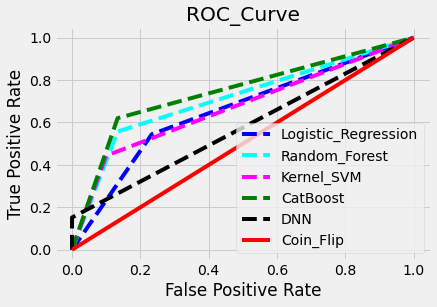

In [61]:
prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, threshold = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr_LR, tpr_LR, linestyle='--', color='blue', label='Logistic_Regression')
plt.plot(fpr_RFC, tpr_RFC, linestyle='--', color='cyan', label='Random_Forest')
plt.plot(fpr_KSV, tpr_KSV, linestyle='--', color='magenta', label='Kernel_SVM')
plt.plot(fpr_CBC, tpr_CBC, linestyle='--', color='green', label='CatBoost')
plt.plot(fpr_DNN, tpr_DNN, linestyle='--', color='black', label='DNN')
plt.plot(prob_fpr, prob_tpr, linestyle='-', color='red', label="Coin_Flip")
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.plot(figsize=(6, 6))
plt.show()

In [62]:
Classification_Report_Summary = (pd.concat([LR_Rep_df, RFC_Rep_df, KSV_Rep_df, CBC_Rep_df, DNN_Rep_df],
                keys=['LR_Rep_df', 'RFC_Rep_df', 'KSV_Rep_df', 'CBC_Rep_df', 'DNN_Rep_df'])).round(decimals=2)

In [63]:
print("------ Classification Report Summary ------")

------ Classification Report Summary ------


In [64]:
Classification_Report_Summary

precision  recall  f1-score  support
LR_Rep_df  0                  0.39    0.77      0.52    30.00
           1                  0.86    0.54      0.67    79.00
           accuracy           0.61    0.61      0.61     0.61
           macro avg          0.62    0.66      0.59   109.00
           weighted avg       0.73    0.61      0.63   109.00
RFC_Rep_df 0                  0.43    0.87      0.57    30.00
           1                  0.92    0.56      0.69    79.00
           accuracy           0.64    0.64      0.64     0.64
           macro avg          0.67    0.71      0.63   109.00
           weighted avg       0.78    0.64      0.66   109.00
KSV_Rep_df 0                  0.38    0.90      0.53    30.00
           1                  0.92    0.44      0.60    79.00
           accuracy           0.57    0.57      0.57     0.57
           macro avg          0.65    0.67      0.57   109.00
           weighted avg       0.77    0.57      0.58   109.00
CBC_Rep_df 0                  0.46    0.87      0.60    30.00
           1                  0.92    0.62      0.74    79.00
           accuracy           0.69    0.69      0.69     0.69
           macro avg          0.69    0.74      0.67   109.00
           weighted avg       0.80    0.69      0.70   109.00
DNN_Rep_df 0                  0.31    1.00      0.47    30.00
           1                  1.00    0.15      0.26    79.00
           accuracy           0.39    0.39      0.39     0.39
           macro avg          0.65    0.58      0.37   109.00
           weighted avg       0.81    0.39      0.32   109.00

### Iteration # 1

Description:
    1. Dataset run with all features.
    2. Downsampling carried out.
    3. Class Count Before Downsampling Dataset
        0          139
        1          327

Output:

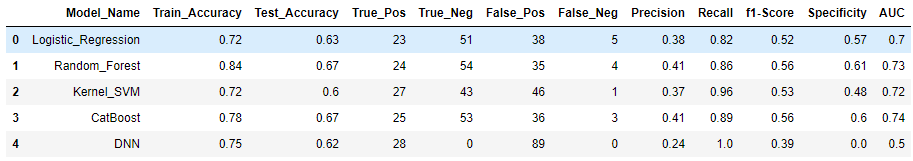

Conclusions:
    1. Accuracy and Recall are not up to the expectations.
    2. Difference is considerably high between Train and Test accuracy. Model generability is desired.
    

Recommendations:
    1. Remove outliers and check.
    2. Carryout feature reduction and check.



### Iteration # 2

Description:
    1. Dataset run with all features.
    2. Downsampling is NOT done.
    3. Outliers are removed. (Not many 47/583)

Output:

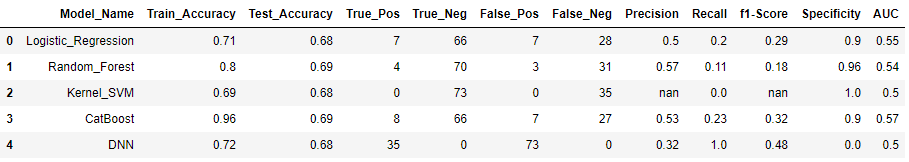

Conclusions:
    1. Downsampling must be done. Without which the scores are bad.

### Iteration # 3

Description:
    1. Outliers removed.
    2. Downsampling carried out.

Output:

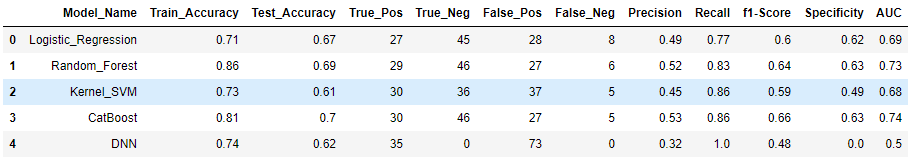

Conclusions:
    1. Iteration 3 has better scores.
    2. However, the difference in train and test accuracy is high.
    3. Certain models show over fitting.

Recommendations:
    1. Drop Total Bilirubin.
    2. Reduce the training set.

### Iteration # 4

Description:
    1. Outliers removed.
    2. Downsampling carried out.
    3. Removed Total Bilirubin
    4. Increased test size from 0.2 to 0.3

Output:

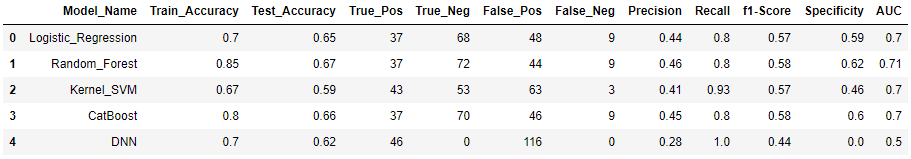

Conclusions:
    1. Increased test size did not improve the overall accuracy and AUC.
    2. It did not reduce the difference between train & test accuracy.
    3. Conditions will be reverted to Iteration # 3.

### Iteration # 5

Description:
    1. Outliers removed.
    2. Downsampling carried out.
    3. Changed Scaler from MinMax to Standard.

Output:

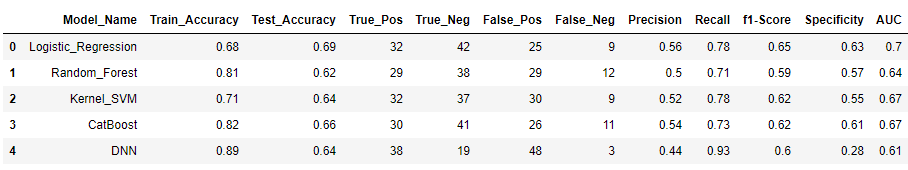

Conclusions:
    1. Model oscillates between Logistic Regression & CatBoost
    2. Try with Top features identified by Decistion Tree Classification.
    

### Iteration # 6

Description:

    1. Top features from Decision Tree Classification (Refer EDA) explaining 95% variation is considered.
    2. All other features are dropped
    3. Downsampling is carried out
    4. Outliers are eliminated.

Output:

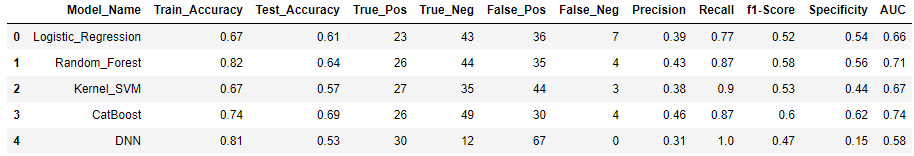

Conclusions:

    1. CatBoost gives a reasonable accuracy.
    2. Train and Test accuracy difference is 5 %. Acceptable.
    3. AUC 0.74. Scope for improvement exists.


In [67]:
!jupyter nbconvert --output-dir='C:\DSML_Case_Studies\01_Classification\00_Final_Reports' MLM_CLF_Dataset_Liver_Patient.ipynb --to html --no-input

C:\ProgramData\Anaconda3\lib\site-packages\traitlets\traitlets.py:2196: FutureWarning: Supporting extra quotes around Unicode is deprecated in traitlets 5.0. Use 'C:\\DSML_Case_Studies\\01_Classification\\00_Final_Reports' instead of "'C:\\DSML_Case_Studies\\01_Classification\\00_Final_Reports'" – or use CUnicode.
  warn(
[NbConvertApp] Converting notebook MLM_CLF_Dataset_Liver_Patient.ipynb to html
[NbConvertApp] Writing 805555 bytes to C:\DSML_Case_Studies\01_Classification\00_Final_Reports\MLM_CLF_Dataset_Liver_Patient.html
